In [2]:
NAME = 'lstm-kinopoisk'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

2024-06-10 20:53:18.830012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import datetime

import mydata as md

data = md.Data('cache')


In [5]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('kinopoisk')

In [6]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [7]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

2024-06-10 20:54:24.130624: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [9]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [11]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=True
)
bidirectional_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5))

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    bidirectional_layer,
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_initializer='he_normal')
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,947 (5.20 MB)

 Trainable params: 1,362,947 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")}"

epochs = 10
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.3864 - f1_score: 0.3673 - loss: 1.0812 - val_accuracy: 0.5547 - val_f1_score: 0.5455 - val_loss: 0.9123
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6010 - f1_score: 0.5915 - loss: 0.8551 - val_accuracy: 0.5673 - val_f1_score: 0.5617 - val_loss: 0.8817
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6986 - f1_score: 0.6953 - loss: 0.6961 - val_accuracy: 0.5667 - val_f1_score: 0.5690 - val_loss: 0.8893
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.7912 - f1_score: 0.7883 - loss: 0.5197 - val_accuracy: 0.5467 - val_f1_score: 0.5487 - val_loss: 1.0177
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.8485 - f1_score: 0.8471 - loss: 0.3902 - val_accuracy: 0.5327 - val_f1_score: 0.5357 - val_loss: 1.1584
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8828 - f1_score: 0.8823 - loss: 0.3051 - val_accuracy: 0.5513 - val_f1_score: 

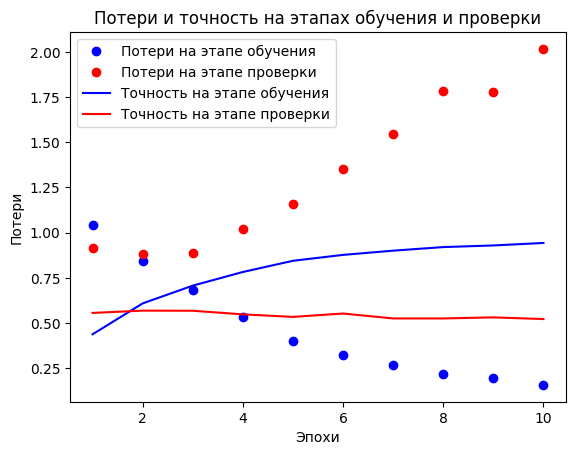

In [13]:
data.plot(history)

In [15]:
model.load_weights(checkpoint_filepath)

In [17]:
model.evaluate(test_ds_batch)

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.5682 - f1_score: 0.5637 - loss: 0.9028


[0.8897585272789001, 0.5759999752044678, 0.5705698132514954]

In [23]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │     1,362,947 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,947 (5.20 MB)

 Trainable params: 1,362,947 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
export_model.save(f'models/model{NAME}.keras')

In [38]:
raw_tab_train_ds, raw_tab_valid_ds, raw_tab_test_ds = data.load('tabiturient')

Проверяем на данных tabiturient

In [44]:
tab_train_ds = data.vectorize(raw_tab_train_ds, vectorize_layer)
tab_valid_ds = data.vectorize(raw_tab_valid_ds, vectorize_layer)
tab_test_ds = data.vectorize(raw_tab_test_ds, vectorize_layer)

In [49]:
model.evaluate(
    tab_test_ds.batch(16)
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4961 - f1_score: 0.4365 - loss: 1.0565


[1.0450749397277832, 0.5027777552604675, 0.4439547061920166]

In [29]:
model.save(f'models/model-{NAME}.keras')

In [50]:
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

In [51]:
checkpoint_filepath = f"models/checkpoint-{NAME}-fine.weights.h5"

log_dir = f"logs/fit-{NAME}-fine/{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"

epochs = 10
history = model.fit(
    tab_train_ds.batch(16),
    validation_data=tab_valid_ds.batch(16),
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        # tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 120s 639ms/step - accuracy: 0.4500 - f1_score: 0.3848 - loss: 1.1028 - val_accuracy: 0.4791 - val_f1_score: 0.4213 - val_loss: 1.0898
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 159s 878ms/step - accuracy: 0.4565 - f1_score: 0.3915 - loss: 1.0855 - val_accuracy: 0.4875 - val_f1_score: 0.4094 - val_loss: 1.0674
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 169s 940ms/step - accuracy: 0.4754 - f1_score: 0.4006 - loss: 1.0832 - val_accuracy: 0.5209 - val_f1_score: 0.4339 - val_loss: 1.0494
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 170s 945ms/step - accuracy: 0.4983 - f1_score: 0.4047 - loss: 1.0437 - val_accuracy: 0.5348 - val_f1_score: 0.4446 - val_loss: 1.0347
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 173s 962ms/step - accuracy: 0.5031 - f1_score: 0.4029 - loss: 1.0346 - val_accuracy: 0.5376 - val_f1_score: 0.4342 - val_loss: 1.0227
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 172s 956ms/step - accuracy: 0.5224 - f1_score: 0.4220 - loss: 1.0211 - val_accuracy: 0.520

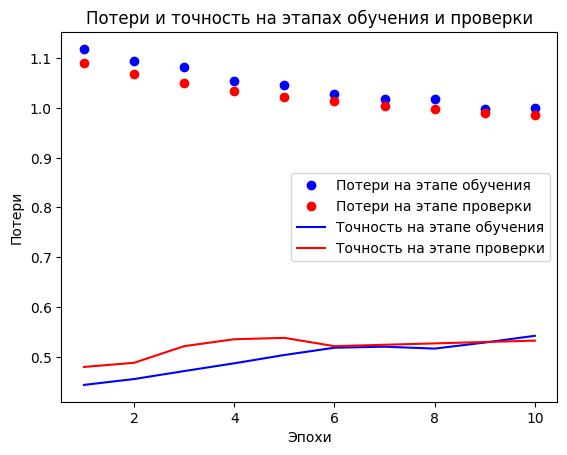

In [52]:
data.plot(history)

In [53]:
model.load_weights(checkpoint_filepath)

In [54]:
model.evaluate(
    tab_test_ds.batch(16)
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5659 - f1_score: 0.4457 - loss: 0.9657


[0.9660437107086182, 0.5611110925674438, 0.450018972158432]